Ideas:

1. Physics simulator with mechanics (blocks) from images and rotating bodies (&their images)
2. GridWorld go to goal, with few obstacles (so that the resulting fcn is simple)

In [98]:
from copy import deepcopy
import numpy as np
import math
from webcolors import name_to_rgb
from matplotlib import pyplot as plt
import cv2
from IPython.display import clear_output

In [99]:
class DelayedExecutor(object):
    """Execute stored commands after a pre-defined number of steps."""
    
    def __init__(self):
        self.queue = []
        self.current_step = 0
        
    def push(self, delay, function):
        """Add a function to execute."""
        assert isinstance(delay, int)
        assert delay >= 0
        assert callable(function)
        self.queue.append((self.current_step + delay, function))
        
    def step(self):
        """One step, will execute/increment step counter."""
        new_queue = []
        
        for target_step, fcn in self.queue:
            if target_step <= self.current_step:
                fcn()
            else:
                new_queue.append((target_step, fcn))
                
        self.queue = new_queue
        self.current_step += 1
        
    def __repr__(self):
        return f"<DE nextstep={self.current_step} queuelen={len(self.queue)}>"

In [100]:
class ProbeFunction(object):
    """Log number of calls for all objects."""
    NUM_OBJECTS = 0
    
    def __init__(self):
        self.num_calls = 0
        self.idx = ProbeFunction.NUM_OBJECTS
        ProbeFunction.NUM_OBJECTS += 1
    def __call__(self):
        self.num_calls += 1
        print(self, "called")
        assert self.num_calls <= 1, f"Too many calls {self}"
        return self
        
    def __repr__(self):
        return f"Probe function {self.idx}, total {self.num_calls}"

In [101]:
def test_delayed_executor():
    de = DelayedExecutor()
    assert len(de.queue) == 0
    f0 = ProbeFunction()
    f1 = ProbeFunction()
    f2 = ProbeFunction()
    de.push(0, f0)
    de.push(1, f1)
    de.push(2, f2)
    de.step()
    assert f0.num_calls == 1
    assert f1.num_calls == 0
    assert f2.num_calls == 0
    de.step()
    assert f0.num_calls == 1
    assert f1.num_calls == 1
    assert f2.num_calls == 0
    de.step()
    assert f0.num_calls == 1
    assert f1.num_calls == 1
    assert f2.num_calls == 1

    for _ in range(10):
        de.step()

    f0 = ProbeFunction()
    f1 = ProbeFunction()
    f2 = ProbeFunction()
    de.push(0, f0)
    de.push(1, f1)
    de.push(2, f2)
    de.step()
    assert f0.num_calls == 1
    assert f1.num_calls == 0
    assert f2.num_calls == 0
    de.step()
    assert f0.num_calls == 1
    assert f1.num_calls == 1
    assert f2.num_calls == 0
    de.step()
    assert f0.num_calls == 1
    assert f1.num_calls == 1
    assert f2.num_calls == 1

In [102]:
test_delayed_executor()

Probe function 0, total 1 called
Probe function 1, total 1 called
Probe function 2, total 1 called
Probe function 3, total 1 called
Probe function 4, total 1 called
Probe function 5, total 1 called


In [115]:
def inrange(x, m, M):
    """x in [m, M]?"""
    return m <= x <= M

class KeyChestEnvironment(object):
    # class constants
    OBJECTS = ['empty', 'wall', 'key', 'chest', 'food', 'lamp_on', 'lamp_off', 'player']
    SYMBOLS = {'wall': '#', 'player': 'P', 'key': '<', 'chest': '>', 'food': '@',
               'lamp_on': 'L', 'lamp_off': 'l', 'empty': ' '}    
    COLORS = {'empty': (191, 191, 191), 'wall': (0, 0, 0), 'key': (0, 0, 255), 'chest': (255, 255, 0), 'lamp_on': (255, 255, 255),
              'lamp_off': (94, 94, 94), 'food': (0, 255, 0), 'player': (255, 0, 0)}
    ACTIONS = {0: (1, 0), 1: (-1, 0), 2: (0, 1), 3: (0, -1)}
    ACTION_NAMES = {(1, 0): "down", (-1, 0): "up", (0, 1): "right", (0, -1): "left"}
    
    def __init__(self, labyrinth_maps, initial_health, food_efficiency,
                 food_rows=None, keys_rows=None, callback=None):
        """Environment with keys and chests."""
        self.initial_maps = deepcopy(labyrinth_maps)
        self.maps = deepcopy(labyrinth_maps)
        self.executor = DelayedExecutor()
        self.delay = 1
        self.shape = self.maps[self.SYMBOLS['empty']].shape
        assert set(self.maps.keys()) == set(KeyChestEnvironment.SYMBOLS.values())
        self.keys = 0
        self.food_efficiency = food_efficiency
        self.food_rows = food_rows
        self.keys_rows = keys_rows
        self.initial_health = initial_health
        self.health = initial_health
        self.width = self.shape[1]
        self.height = self.shape[0]
        self.first_render = True
        self.callback_ = callback
        
        # to see if everything fits
        self.render()
        
        self.moves = 0
        self.history = []
        
        self.callback(dict(event='initialized'))
        
    def callback(self, *args, **kwargs):
        if self.callback_:
            self.callback_(*args, moves=self.moves, **kwargs)
        else:
            pass
        self.history.append(dict(args=args, kwargs=kwargs, moves=self.moves))
        
    @property
    def player_position(self):
        return self.locate_single(self.SYMBOLS['player'])
        
    def items_at_position(self, pos):
        """Which items are at a particular position?"""
        return [x for x in self.SYMBOL_LIST if self.maps[x][pos[0], pos[1]]]
    
    def item_at_position(self, pos):
        """Got one item at a position."""
        items = self.items_at_position(pos)
        if len(items) == 2 and self.SYMBOLS['empty'] in items:
            del items[items.index(self.SYMBOLS['empty'])]
        assert len(items) == 1, f"Must have one items only at {pos}, got {items}"
        return items[0]
    
    @property
    def observation(self):
        sx, sy = self.shape
        
        if self.first_render:
            maxfood = self.initial_health + self.food_efficiency * np.sum(self.initial_maps[self.SYMBOLS['food']])
            maxkeys = np.sum(self.initial_maps[self.SYMBOLS['key']])
            food_rows = round(math.ceil(1. * maxfood / (2 + self.width)))
            keys_rows = round(math.ceil(1. * maxkeys / (2 + self.width)))

            if self.food_rows is None:
                self.food_rows = food_rows
            else:
                assert self.food_rows >= food_rows

            if self.keys_rows is None:
                self.keys_rows = keys_rows
            else:
                assert self.keys_rows >= keys_rows
                
            print(self.keys_rows, self.food_rows)
            self.first_render = False
        
        dy1 = 1
        dy2 = 1
        dy = dy1 + dy2
        dx1 = 1 + self.food_rows + self.keys_rows
        dx2 = 1
        dx = dx1 + dx2
        
        def fill_n(arr, offset_x, value, symbol):
            value_left = value
            width = arr.shape[1]
            current_row = offset_x
            while value_left:
                add_this_iter = min(width, value_left)
                arr[current_row, :add_this_iter] = [symbol] * add_this_iter
                current_row += 1
                value_left -= add_this_iter
        
                
        shape = (sx + dx, sy + dy)
        out = np.full(fill_value=self.SYMBOLS['empty'], shape=shape, dtype='<U1')
        
        fill_n(out, 0, self.health, self.SYMBOLS['food'])
        fill_n(out, self.food_rows, self.keys, self.SYMBOLS['key'])
        
        out[dx1 - 1, :] = self.SYMBOLS['wall']
        out[-1, :] = self.SYMBOLS['wall']
        out[dx1 - 1:, 0] = self.SYMBOLS['wall']
        out[dx1 - 1:, -1] = self.SYMBOLS['wall']
        for obj in self.OBJECTS:
            symb = self.SYMBOLS[obj]
            mask = self.maps[symb] > 0
            out[dx1:-dx2,dy1:-dy2][mask] = self.SYMBOLS[obj]
            
        return out
        
    def move_symbol(self, symbol, old_pos, new_pos):
        self.delete_symbol(symbol, old_pos)
        self.add_symbol(symbol, new_pos)
        
    def delete_symbol(self, symbol, old_pos):
        assert self.maps[symbol][old_pos[0], old_pos[1]]
        self.maps[symbol][old_pos[0], old_pos[1]] = False
        
    def add_symbol(self, symbol, new_pos):
        assert not self.maps[symbol][new_pos[0], new_pos[1]]
        self.maps[symbol][new_pos[0], new_pos[1]] = True
        
    def step(self, action):
       
        info = {'action': action, 'event': 'regular_move'}
                
        next_position = np.array(self.player_position) + np.array(self.ACTIONS[action])
        if not inrange(next_position[0], 0, self.height - 1):
            def change_callback(info=info):
                info['event'] = 'bump_top_or_bottom'
                return info
        elif not inrange(next_position[1], 0, self.width - 1):
            def change_callback(info=info):
                info['event'] = 'bump_left_or_right'
                return info
        else:
            self.move_symbol(self.SYMBOLS['player'], self.player_position, next_position)
            
            def change_callback(self=self, next_position=next_position, info=info):
                # otherwise we are moving
                item = self.item_at_position(next_position)

                if item == self.SYMBOLS['wall']:
                    info['event'] = 'bump_wall'

                if item == self.SYMBOLS['lamp_on']:
                    self.delete_symbol(self.SYMBOLS['lamp_on'], next_position)
                    self.add_symbol(self.SYMBOLS['lamp_off'], next_position)

                    info['event'] = 'lamp_turned_off'
                elif item == self.SYMBOLS['lamp_off']:
                    self.delete_symbol(self.SYMBOLS['lamp_off'], next_position)
                    self.add_symbol(self.SYMBOLS['lamp_on'], next_position)

                    info['event'] = 'lamp_turned_on'
                elif item == self.SYMBOLS['food']:
                    self.delete_symbol(self.SYMBOLS['food'], next_position)
                    self.health += self.food_efficiency

                    info['event'] = 'food_collected'
                elif item == self.SYMBOLS['key']:
                    self.delete_symbol(self.SYMBOLS['key'], next_position)
                    self.keys += 1

                    info['event'] = 'key_collected'
                elif item == self.SYMBOLS['chest']:
                    if self.keys > 0:
                        self.keys -= 1
                        self.delete_symbol(self.SYMBOLS['chest'], next_position)
                        info['event'] = 'chest_opened'
                    else:
                        info['event'] = 'not_enough_keys'
                else:
                    info['event'] = 'regular_move'

                return info
            
        
        def move_effect(self=self, change_callback=change_callback):
            info = change_callback()
            self.callback(info)
        
        self.executor.push(self.delay, move_effect)
        self.executor.step()
        self.moves += 1
        return self.observation
        
        
    def render(self, mode='np_array'):
        obs = self.observation
        
        if mode == 'np_array':
            return obs
        elif mode == 'str':
            return '\n'.join([''.join(x) for x in obs])
        elif mode == 'rgb_array':
            scale = 5
            out_arr = np.zeros((obs.shape[0], obs.shape[1], 3))
            for symbol in self.SYMBOL_LIST:
                mask = obs == symbol
                out_arr[mask] = self.SYMBOLS_TO_COLORS[symbol]
            out_arr /= 255.

            out_arr = np.repeat(out_arr, scale, axis=1)
            out_arr = np.swapaxes(np.repeat(np.swapaxes(out_arr, 0, 1), scale, axis=1), 0, 1)
            return out_arr
        
        return obs
        
    def locate(self, object_type):
        return KeyChestEnvironment._locate(self.maps, object_type)
    
    def locate_single(self, object_type):
        return KeyChestEnvironment._locate_single(self.maps, object_type)
    
    @staticmethod
    def _locate(maps, object_type):
        """Where are objects of a given type on the map?"""
        assert object_type in KeyChestEnvironment.SYMBOLS.values(), \
            f"Wrong object {object_type}, have {maps.keys()}"
        return list(zip(*np.where(maps[object_type])))
    
    @staticmethod
    def _locate_single(maps, object_type):
        """Where is the single object?"""
        w = KeyChestEnvironment._locate(maps, object_type)
        assert len(w) >= 1, f"No {object_type} found"
        assert len(w) <= 1, f"More than one {object_type} found"
        return w[0]
    
def compute_attrs(cls=KeyChestEnvironment):
    """Set additional attributes."""
    cls.SYMBOLS_TO_OBJECTS = {y: x for x, y in cls.SYMBOLS.items()}
    cls.SYMBOL_LIST = [cls.SYMBOLS.get(x) for x in cls.OBJECTS]
    cls.SYMBOLS_TO_COLORS = {x: cls.COLORS[cls.SYMBOLS_TO_OBJECTS[x]] for x in cls.SYMBOL_LIST}
    cls.ACTIONS_REVERSE = {y: x for x, y in cls.ACTIONS.items()}
    cls.ACTION_NAME_REVERSE = {y: x for x, y in cls.ACTION_NAMES.items()}
    
compute_attrs(KeyChestEnvironment)

In [116]:
class KeyChestEnvironmentRandom(KeyChestEnvironment):
    
    def __init__(self, width=10, height=10, n_keys=2, n_chests=2, n_food=2, **kwargs):
        objects_to_fill = ['player', 'lamp_off']
        objects_to_fill += ['key'] * n_keys
        objects_to_fill += ['chest'] * n_chests
        objects_to_fill += ['food'] * n_food
        shape = (height, width)
        wh = width * height
        assert wh >= len(objects_to_fill)
        
        positions = []
        for i in range(height):
            for j in range(width):
                positions.append((i, j))
                
        pos_select = np.random.choice(range(len(positions)), len(objects_to_fill), replace=False)
        
        maps = {k: np.zeros(shape, dtype=np.bool) for k in self.SYMBOLS.values()}
        maps[self.SYMBOLS['empty']][:,:] = True
                
        for pos, obj in zip(pos_select, objects_to_fill):
            m = maps[self.SYMBOLS[obj]]
            p = positions[pos]
            m[p[0], p[1]] = True
        
        super(KeyChestEnvironmentRandom, self).__init__(labyrinth_maps=maps, **kwargs)

In [120]:
buffer = None
def callback_store(x, moves=None):
    global buffer
    buffer = (moves, x)

In [121]:
env = KeyChestEnvironmentRandom(initial_health=13, food_efficiency=10, callback=callback_store)

1 3


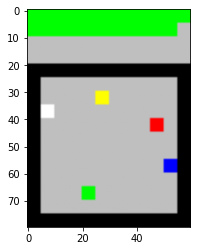

down (1, 0) 0
(38, {'action': 0, 'event': 'chest_opened'})


In [ ]:
plt.imshow(env.render('rgb_array'))
plt.show()

while True:
    key = input()
    clear_output()
    mapping = {'w': 'up', 'a': 'left', 's': 'down', 'd': 'right'}
    try:
        key = mapping[key]
        dxdy = env.ACTION_NAME_REVERSE[key]
        act = env.ACTIONS_REVERSE[dxdy]
    except:
        print("Wrong action")
    env.step(act)
    plt.show()
    plt.imshow(env.render('rgb_array'))
    plt.show()
    print(key, dxdy, act)
    print(buffer)


In [60]:
_ = env.step(0)

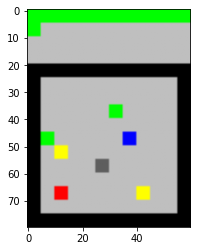

In [61]:
plt.imshow(env.render('rgb_array'))

In [38]:
env.step(0)

7 {'action': 0, 'event': 'bump_top_or_bottom'}


array([['@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@'],
       ['@', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       ['#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#'],
       ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '@', ' ', ' ', '#'],
       ['#', 'l', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
       ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
       ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
       ['#', ' ', ' ', '<', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
       ['#', ' ', ' ', ' ', ' ', ' ', ' ', '<', ' ', ' ', ' ', '#'],
       ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
       ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
       ['#', ' ', '@', ' ', '>', '>', ' ', ' ', ' ', ' ', ' ', '#'],
       ['#', ' ', ' ', ' ', ' ', '

In [39]:
print(env.render('str'))

@@@@@@@@@@@@
@           
            
            
############
#       @  #
#l         #
#          #
#          #
#  <       #
#      <   #
#          #
#          #
# @ >>     #
#     P    #
############


In [40]:
arr = env.observation

In [41]:
env.SYMBOLS_TO_COLORS

{' ': (191, 191, 191),
 '#': (0, 0, 0),
 '<': (0, 0, 255),
 '>': (255, 255, 0),
 '@': (0, 255, 0),
 'L': (255, 255, 255),
 'l': (94, 94, 94),
 'P': (255, 0, 0)}

In [ ]:
scale = 10

In [ ]:
env

In [ ]:
arr = np.array([[1,2,3],
         [4,5,6]])
arr

In [135]:
import gym, pickle

In [136]:
space = gym.spaces.Box(np.array([-1]), np.array([1.0]))

In [149]:
dir(space)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'bounded_above',
 'bounded_below',
 'contains',
 'dtype',
 'from_jsonable',
 'high',
 'is_bounded',
 'low',
 'np_random',
 'sample',
 'seed',
 'shape',
 'to_jsonable']

In [196]:
def save_gym_space(space):
    """Serialize gym.space."""
    if isinstance(space, gym.spaces.Box):
        low = space.low.flatten()[0]
        high = space.high.flatten()[0]
        return dict(type_='Box', low=low, high=high,
                    shape=space.shape, dtype=space.dtype)
    raise TypeError(f"Type {type(space)} is unsupported")
    
def load_gym_space(d):
    """Load gym.space from save_gym_space result."""
    assert isinstance(d, dict)
    if d['type_'] == 'Box':
        return gym.spaces.Box(low=d['low'], high=d['high'],
                              shape=d['shape'], dtype=d['dtype'])
    raise TypeError(f"Type {d['type_']} is unsupported")

In [197]:
load_gym_space(save_gym_space(space))

Box(1,)

In [206]:
isinstance(space, gym.spaces.Box)
import codecs

In [199]:
load_gym_space({'sdf': 1, 'type_': 1})

TypeError: Type 1 is unsupported

In [209]:
codecs.encode(pickle.dumps(123), "hex")

b'80034b7b2e'